<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/b/bd/Tesla_Motors.svg" width="200" height="200"><br>
</center>

# 1. 야후 파이낸스를 이용한 테슬라 주가 분석하기

이번엔 테슬라 주가에 대한 분석을 해보려고 한다. 주가처럼 연속적인 시간에 따라 다르게 측정되는 데이터를 시계열 데이터라 하며, 이를 분석하는 것을 '시계열 데이터 분석' 이라고 한다. 

### step.1 탐색: 날짜 정보가 포함된 데이터 살펴보기

데이터 출처 : 야후 파이낸스 (https://finance.yahoo.com/), 이것이 데이터 분석이다.(3-2 비트코인 시세분석 참조)


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

tsla_df의 기본정보를 확인해보자.

In [102]:
# 야후 파이낸스로 데이터를 불러오자. 구글에 TSLA ticker를 치면 오른쪽에 나오는 코드 TSLA 을 입력하면 된다.
tsla_df = yf.download('TSLA',
                      start='2019-01-01',
                      end='2021-03-31',
                      progress=False)

# 테슬라 주가의 종가(Close)로 분석을 해볼것이다.
tsla_df = tsla_df[["Close"]]

# 인덱스를 초기화 시킨다.
tsla_df = tsla_df.reset_index()

# 컬럼의 이름을 day, price로 바꾼다.
tsla_df.columns = ['day', 'price']

# Pandas DataFrame 열을 Python datetime 으로 변환한다.
tsla_df['day'] = pd.to_datetime(tsla_df['day'])

# 인덱스를 다시 지정해준다.
tsla_df.index = tsla_df['day']
tsla_df.set_index('day', inplace=True)

tsla_df

,price
day,
2018-12-31,66.559998
2019-01-02,62.023998
2019-01-03,60.071999
2019-01-04,63.537998
2019-01-07,66.991997
...,...
2021-03-24,630.270020
2021-03-25,640.390015
2021-03-26,618.710022


분석에 필요한 라이브러리를 불러온다. 그리고 Date와 Close의 피처 이름을 각각 day와 price로 바꿔준다.
주가 분석을 위한 데이터는 주가 변동이 컸었던 2019-01-1부터 2021-03-31까지만 불러왔다.
이 때 유독 테슬라의 주가가 변동이 컸던 이유는 코로나로 인한 돈의 흐름이 비트코인과 주식에 몰렸었고, 또 전세계적으로 친환경 정책이 전기차 시장에서 앞서 갔던 테슬라에게 유리하게 돌아가 주가 폭등의 이유가 되었다. 그리고 최근 미국 대통령으로 당선된 바이든의 ESG 정책으로 더 날개를 달았다.


In [5]:
print(tsla_df.shape)
print(tsla_df.info())
tsla_df.tail()

(566, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 566 entries, 2018-12-31 to 2021-03-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   566 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB
None


,price
day,
2021-03-24,630.270020
2021-03-25,640.390015
2021-03-26,618.710022
2021-03-29,611.289978
2021-03-30,635.619995


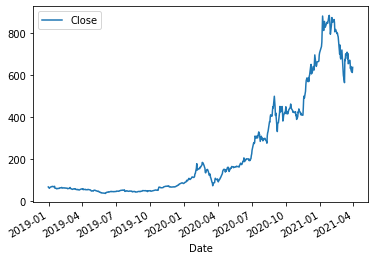

In [6]:
tsla_df = yf.download('TSLA',
start='2019-01-01',
end='2021-03-31',
progress=False)

tsla_df = tsla_df[["Close"]]

tsla_df.plot()
plt.show()

원래 데이터에는 총 5개의 피처가 있는데 우리는 종가(Close)만 가져와서 분석을 해보자.
위 코드를 입력하면 2019년 1월부터 2021년 3월까지의 Close의 추이를 볼 수 있다.

In [9]:
tsla_train_df = tsla_df[:561]
tsla_train_df
tsla_test_df = tsla_df[561:]
tsla_test_df

,Close
Date,
2021-03-24,630.270020
2021-03-25,640.390015
2021-03-26,618.710022
2021-03-29,611.289978
2021-03-30,635.619995


### step.2 예측: 파이썬 라이브러리를 활용해 시세 예측하기
이번 절에서 첫 번째로 사용할 시계열 예측 분석 방법은 ARIMA 분석 방법이다.


- ARIMA 모델 활용하기

In [10]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action='ignore')

# (AR = 2, 차분 =1, MA=2) 파라미터로 ARIMA 모델을 학습한다.
model = ARIMA(tsla_train_df.Close.values, order = (2,1,2))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  560
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2295.780
Method:                       css-mle   S.D. of innovations             14.517
Date:                Wed, 21 Apr 2021   AIC                           4603.560
Time:                        21:20:37   BIC                           4629.528
Sample:                             1   HQIC                          4613.700
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0687      0.605      1.766      0.077      -0.117       2.255
ar.L1.D.y      0.1691      0.013     12.667      0.000       0.143       0.195
ar.L2.D.y     -0.9559      0.013    -72.262      0.0

다음으로 ARIMA 모델의 학습 결과를 알아보자. 아래의 실행 결과 중 첫 번째 그래프는 학습한 모델에 학습 데이터셋을 넣었을 때의 시계열 예측 결과이다.


두 번째 그래프는 실제값과 예측값 사이의 오차 변동을 나타내는 그래프이다. 데이터를 보면 2020년에 테슬라 주가가 폭등한다. 그에 따라 오차변동을 나타내는 그래프의 변동이 매우 심하게 나타난다. 이는 실제는 주가가 폭등했지만 예측값은 그렇지 않았다는 것을 알 수 있다.

Text(0.5, 1.0, 'resid')

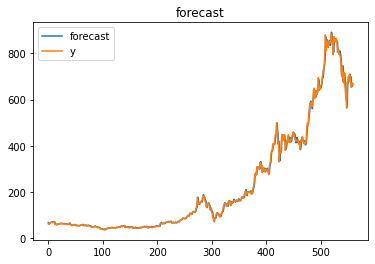

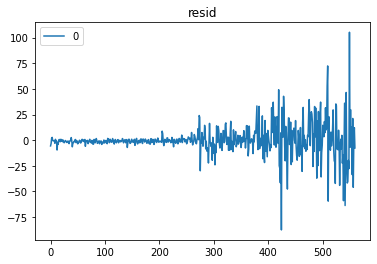

In [94]:
fig = model_fit.plot_predict() 
plt.title('forecast')

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('resid')

다음으로 ARIMA 모델을 평가해보자. 모델을 평가하기 위해서는 테스트 전용 데이터가 필요한데 이번 예제에서는 5일 동안의 미래를 테스트 데이터로 사용하자.

- ARIMA 모델 평가

In [45]:
forecast_data = model_fit.forecast(steps=5)

tsla_train_df = tsla_df[:561]
tsla_train_df
tsla_test_df = tsla_df[561:]
tsla_test_df

pred_y = forecast_data[0].tolist()
test_y = tsla_test_df.Close.values

pred_y_lower = []
pred_y_upper = []
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

그리고 다음 코드는 이를 그래프로 시각화한 것이다. 파란색은 모델이 예상한 최고 가격, 빨간색은 모델이 예측한 하한가 그래프이고, 초록색은 실제 5일 간의 가격 그래프, 노란색은 모델이 예측한 5일간의 가격 그래프를 나타낸 것이다.

Text(3.5, 640, 'test_y')

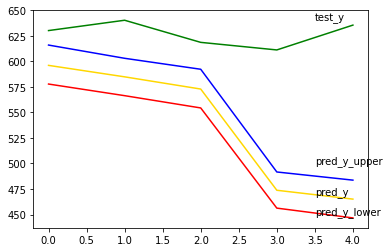

In [103]:
plt.plot(pred_y, color="gold")
plt.text(3.5, 470, 'pred_y')
plt.plot(pred_y_lower, color="red")
plt.text(3.5, 450, 'pred_y_lower')
plt.plot(pred_y_upper, color="blue")
plt.text(3.5, 500, 'pred_y_upper')
plt.plot(test_y, color="green")
plt.text(3.5, 640, 'test_y')

아래코드는 상한가와 하한가를 제외한 뒤 그래프를 살펴보았다. 그래프의 상승 경향을 살펴보면 좋은 예측은 하지 못한것 같다. 실제 중간 구간에서는 주가가 하향세를 보이는데 예측은 계속 상승세를 보이기 때문이다.

Text(3.5, 480, 'test_y')

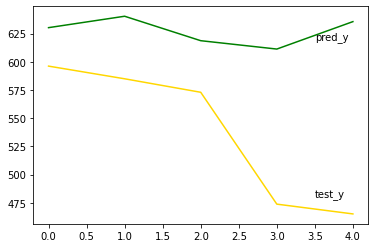

In [105]:
plt.plot(pred_y, color="gold")
plt.text(3.5, 620, 'pred_y')
plt.plot(test_y, color="green")
plt.text(3.5, 480, 'test_y')

In [106]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

104.23190165188085


이번엔 ARIMA보다 조금 더 정확한 트렌드 예측 분석을 제공하는 라이브러리 'FacebookProphet'을 사용하자.

- facebook Prophet 활용하기

In [107]:
from fbprophet import Prophet

In [108]:
tsla_df = yf.download('TSLA',
                      start='2019-01-01',
                      end='2021-03-31',
                      progress=False)

tsla_df = tsla_df[["Close"]]

tsla_df = tsla_df.reset_index()

tsla_df.columns = ['ds', 'y']

prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(tsla_df)

In [109]:
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [110]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
566,2021-03-31,119.919073,577.445029,614.285015,119.919073,119.919073,4.416744,4.416744,4.416744,3.971386,...,0.223089,0.223089,0.223089,-0.668447,-0.668447,-0.668447,0.0,0.0,0.0,596.163989
567,2021-04-01,120.045103,567.956082,604.124243,120.045103,120.045103,4.416744,4.416744,4.416744,3.872578,...,0.213277,0.213277,0.213277,-0.757444,-0.757444,-0.757444,0.0,0.0,0.0,584.929076
568,2021-04-02,120.171132,554.461868,591.636523,120.171132,120.171132,4.416744,4.416744,4.416744,3.767860,...,0.195131,0.195131,0.195131,-0.844015,-0.844015,-0.844015,0.0,0.0,0.0,572.959155
569,2021-04-03,120.297162,455.473527,492.366328,120.297162,120.297162,4.416744,4.416744,4.416744,2.938356,...,-0.552093,-0.552093,-0.552093,-0.926295,-0.926295,-0.926295,0.0,0.0,0.0,473.773084
570,2021-04-04,120.423192,446.621447,483.211141,120.423192,120.423192,4.416744,4.416744,4.416744,2.862184,...,-0.552093,-0.552093,-0.552093,-1.002467,-1.002467,-1.002467,0.0,0.0,0.0,465.096473


In [111]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
566,2021-03-31,596.163989,577.445029,614.285015
567,2021-04-01,584.929076,567.956082,604.124243
568,2021-04-02,572.959155,554.461868,591.636523
569,2021-04-03,473.773084,455.473527,492.366328
570,2021-04-04,465.096473,446.621447,483.211141


다음은 fbprophet 모델의 학습 결과를 시각화한 결과이다. 그래프의 검은점은 실제 가격을 파란 선은 예측 가격을 나타낸 것이다.

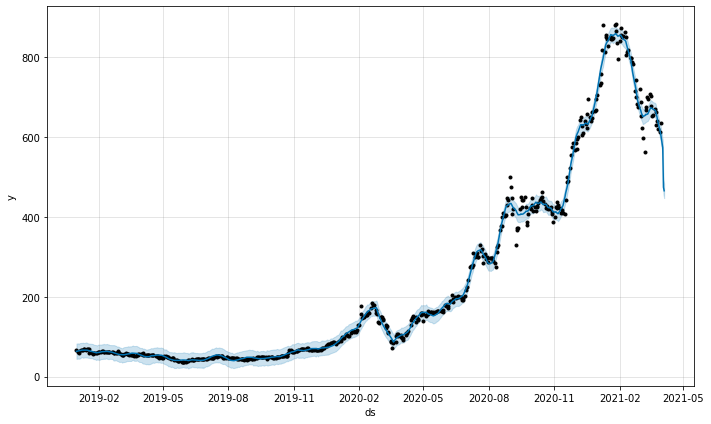

In [112]:
fig1 = prophet.plot(forecast_data)

그리고 다음의 그래프는 fbprophet에서 제공하는 트렌드 정보 시각화 그래프이다. 앞서 seasonality_mode 파라미터를 설정해놓은 경우에만 이 시각화가 가능하다.

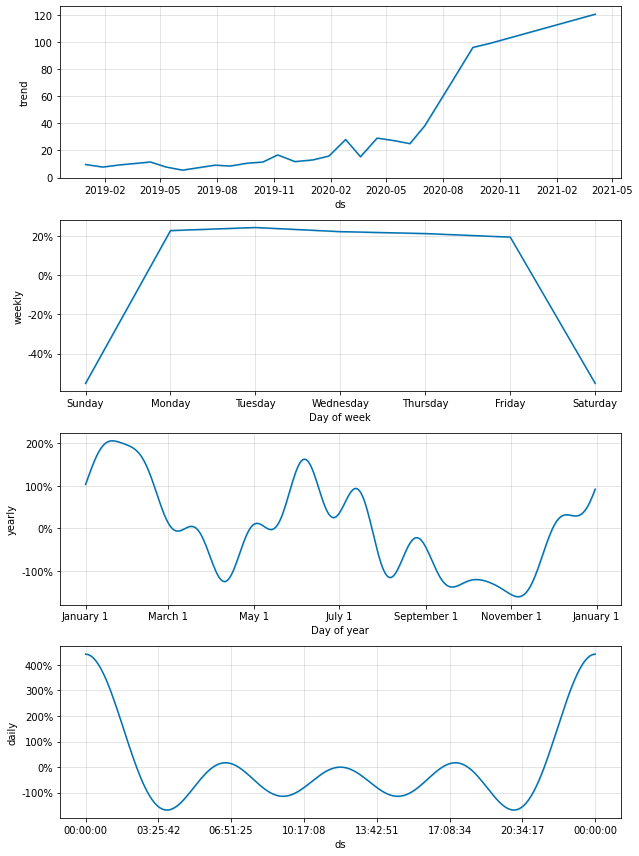

In [113]:
fig2 = prophet.plot_components(forecast_data)

ARIMA 모델을 평가한 것과 동일한 방법으로 테스트 데이터셋을 평가해보자. 아래 코드 실행 결과 ARIMA 모델보다는 prophet 모델이 조금 더 예측 결과가 좋다.

- Facebook Prophet 활용하기 : 실제 데이터와의 비교

In [114]:
tsla_df = yf.download('TSLA',
                      start='2019-01-01',
                      end='2021-03-31',
                      progress=False)

tsla_df = tsla_df[["Close"]]

tsla_df = tsla_df.reset_index()

tsla_df.columns = ['ds', 'y']

pred_y = forecast_data.yhat.values[-5:]
test_y = tsla_test_df.Close.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

Text(3.5, 625, 'test_y')

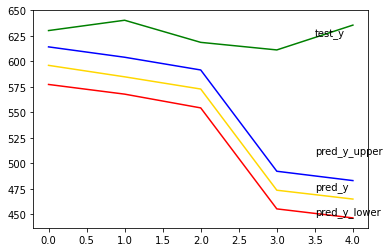

In [117]:
plt.plot(pred_y, color="gold")
plt.text(3.5, 475, 'pred_y')
plt.plot(pred_y_lower, color="red")
plt.text(3.5, 450, 'pred_y_lower')
plt.plot(pred_y_upper, color="blue") 
plt.text(3.5, 510, 'pred_y_upper')
plt.plot(test_y, color="green")
plt.text(3.5, 625, 'test_y')

다음으로 이 모델의 Test RMSE를 ARIMA 모델과 비교해 보자.

Text(3.5, 625, 'test_y')

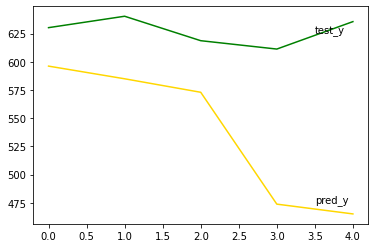

In [127]:
plt.plot(pred_y, color="gold")
plt.text(3.5, 475, 'pred_y')
plt.plot(test_y, color="green")
plt.text(3.5, 625, 'test_y')

In [119]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

104.23190165188085


### step.3 활용: 더 나은 결과를 위한 방법



이번 분석 단계에서는 모델의 성능을 조금 더 향상시킬 수 있는 방법들에 대해 알아보자.
첫 번째로 고려해볼 방법은 상한값 혹은 하한값을 지정해 주는 것이다. 바닥과 천장이 없는 주가 데이터의 경우에는 의미가 없을 수 있지만 일반적인 시계열 데이터에서는 상한값 혹은 하한값을 설정해 주는 것이 모델의 성능을 높여줄 수 있는 방법 중 하나이다.

- 상한가 및 하한가 설정하기

In [120]:
tsla_df = yf.download('TSLA',
                      start='2019-01-01',
                      end='2021-03-31',
                      progress=False)

tsla_df = tsla_df[["Close"]]

tsla_df = tsla_df.reset_index()

tsla_df.columns = ['ds', 'y']

tsla_df['cap'] = 900

prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(tsla_df)

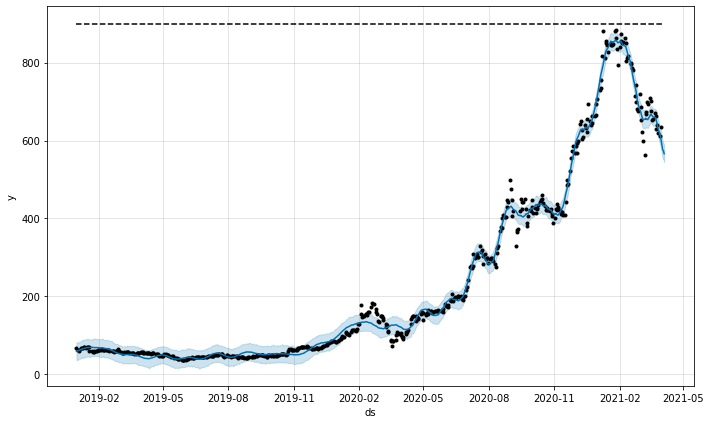

In [121]:
future_data = prophet.make_future_dataframe(periods=5, freq='d')

future_data['cap'] = 900
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

이번엔 아래의 코드로 예측값과 실제값을 비교해보자.

- 예측과 실제 비교 그래프

In [122]:
tsla_df = yf.download('TSLA',
                      start='2019-01-01',
                      end='2021-03-31',
                      progress=False)

tsla_df = tsla_df[["Close"]]

tsla_df = tsla_df.reset_index()

tsla_df.columns = ['ds', 'y']

pred_y = forecast_data.yhat.values[-5:]
test_y = tsla_test_df.Close.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

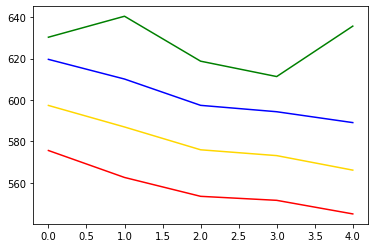

In [123]:
plt.plot(pred_y, color="gold") 
plt.text(3.5, 625, 'pred_y')
plt.plot(pred_y_lower, color="red")
plt.text(3.5, 625, 'test_y')
plt.plot(pred_y_upper, color="blue") 
plt.text(3.5, 625, 'test_y')
plt.plot(test_y, color="green")
plt.text(3.5, 625, 'test_y')

상한선을 정해 놓고 그래프를 살펴보니 전에 분석했던 것보다는 조금이나마 나아진 것을 볼 수 있다. 하지만 실제 주가 폭등을 예측하지는 못하였다.

이제 모델의 성능을 향상시키는 다른 방법 중 하나인 이상치 제거 기법을 살펴보자. 이상치란 평균적인 수치에 비해 지나치게 높거나 낮은 수치의 데이터를 의미한다. fbprophet 모델이 이상치를 제거한 데이터로 학습하려면 이상치에 해당하는 데이터를 None으로 설정해 주면 된다. 아래 코드에선 1000 이상을 이상치라 설정하였다.

- 이상치 제거하기


In [124]:
tsla_df = yf.download('TSLA',
                      start='2019-01-01',
                      end='2021-03-31',
                      progress=False)

tsla_df = tsla_df[["Close"]]

tsla_df = tsla_df.reset_index()

tsla_df.columns = ['ds', 'y']

tsla_df.loc[tsla_df['y'] > 2000, 'y'] = None

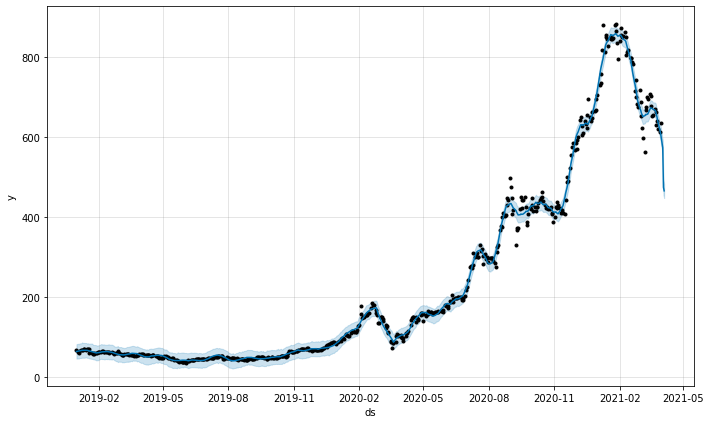

In [125]:
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)

prophet.fit(tsla_df)

future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

마찬가지 방법으로 예측값과 실제값을 그래프로 나타내보자.


In [126]:
tsla_df = yf.download('TSLA',
                      start='2019-01-01',
                      end='2021-03-31',
                      progress=False)

tsla_df = tsla_df[["Close"]]

tsla_df = tsla_df.reset_index()

tsla_df.columns = ['ds', 'y']

pred_y = forecast_data.yhat.values[-5:]
test_y = tsla_test_df.Close.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

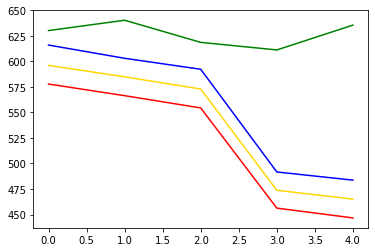

In [69]:
plt.plot(pred_y, color="gold" 
plt.plot(pred_y_lower, color="red") 
plt.plot(pred_y_upper, color="blue") 
plt.plot(test_y, color="green")

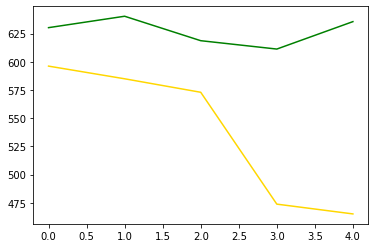

In [70]:
plt.plot(pred_y, color="gold")
plt.plot(test_y, color="green")

In [71]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

104.23190165188085


이상치 제거는 facebook prophet 모델과 거의 동일하게 분석되어 나왔다. 이상치제거는 큰 의미가 없어보인다.